In [190]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns

%matplotlib inline

## About

It’s football season!! With the 2018 season set to begin on September 6, 2018, I’m interested in looking at the public records of police arrests at NFL stadiums. Can stadium staff know when they need to request more police? Do states with higher alcohol consumption per capita (aged over 21) suggest a higher number of arrests?

## Goals

Evaluate public records of police arrests at NFL stadiums and alcohol consumption for each US state to determine if there is a trend or a factor that indicates a high number of arrests.

## Initial Research Findings

The number of arrests for each year are similar, with no trend. 

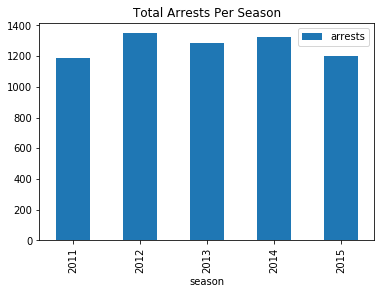

In [191]:
stadium_arr = pd.read_csv('./Data/arrests.csv')

stadium_arr.pivot_table(index='season', values='arrests', aggfunc='sum').plot(kind='bar', title='Total Arrests Per Season')
plt.savefig('arrestsPerYear.png', bbox_inches='tight')

In [192]:
avg_arrests = stadium_arr.pivot_table(index='season', values='arrests', aggfunc='mean')
avg_arrests

,arrests
season,
2011,6.214660
2012,7.020833
2013,6.500000
2014,6.750000
2015,6.338624


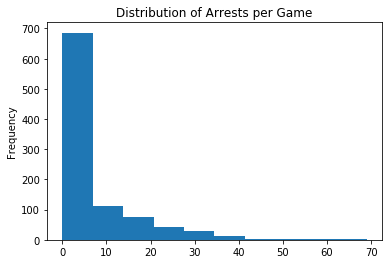

In [193]:
stadium_arr.arrests.plot(kind='hist', title='Distribution of Arrests per Game')
plt.savefig('distributionOfArrestsPerGame.png', bbox_inches='tight')

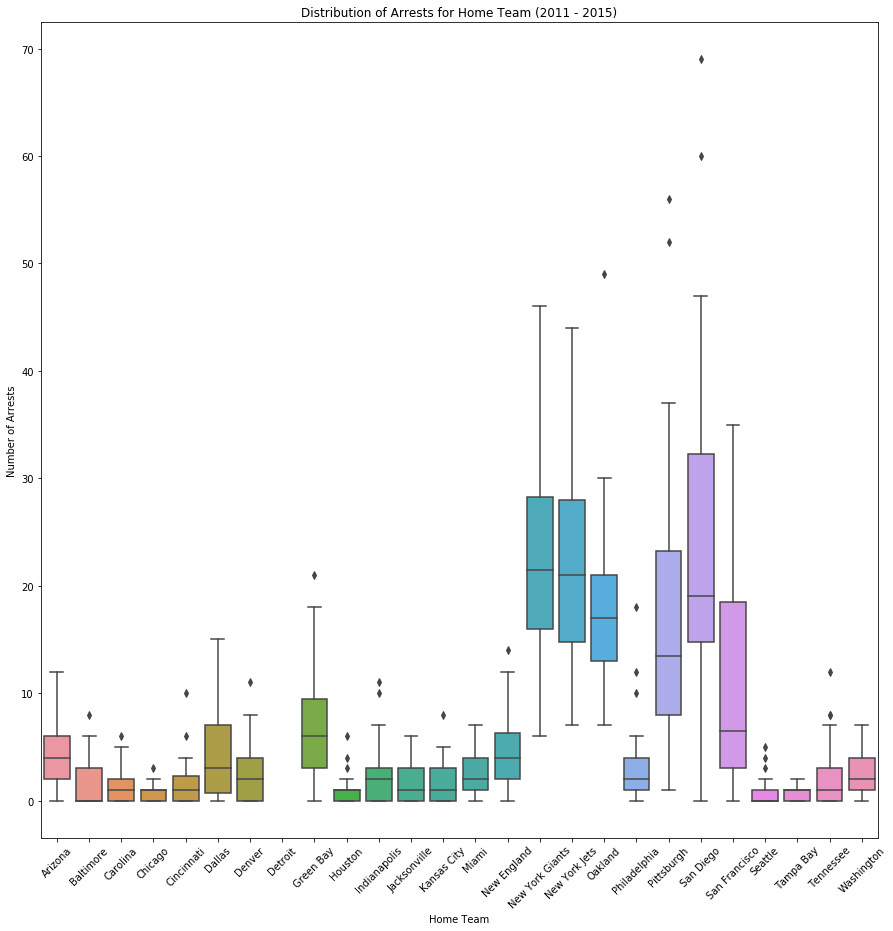

In [221]:
plt.figure(figsize=(15,15))
ax = sns.boxplot(x='home_team', y='arrests', data=stadium_arr)
plt.xlabel('Home Team')
plt.ylabel('Number of Arrests')
plt.title('Distribution of Arrests for Home Team (2011 - 2015)')
plt.xticks(rotation=45)
plt.savefig('ArrestHomeBoxPlot.png', bbox_inches='tight')
plt.show()

In [195]:
stadium_arr.arrests.describe()

count    966.000000
mean       6.566253
std        9.512101
min        0.000000
25%        1.000000
50%        3.000000
75%        8.000000
max       69.000000
Name: arrests, dtype: float64

## Approach

The stadium arrests data was acquired from kaggle. The data contained arrests from 2011 - 2015 of public police records of arrests made at NFL stadiums. Note this dataset predates the recent moves by the Chargers, Rams, and Raiders.

To aid in my analysis, data on per capita alcohol consumption by State and type of alcoholic beverage for the years from 1970 - 2016 was acquired from The National Institute on Alcohol Abuse and Alcoholism (Surveillance Report #110). For consistency, my analysis only contains data from years 2011 - 2015. 

After the datasets were cleaned, they were left joined on stadium arrests to analyize the relationship.

## Cleaning the Data

The stadium arrests data contained attributes for the season (year), week number, day of the week, and time the game occurred.  It further details the home team and away team, and the respective final scores. Finally, the data contains the number of arrests made at the game and categorical variables for if there was overtime and if it was a division game. 

To analyze the dataset more, I created dummy variables for `OT_flag` and for `game_result` (whether or not the home team won). Additionally, I created variables for the hour of the `game_time` and the absolute difference of the final score - `score_diff`. 

In [196]:
#create numeric indicator for OT_flag
stadium_arr['OT'] = pd.get_dummies(stadium_arr['OT_flag'])

# change gametime to datetime object
stadium_arr['gametime_local'] = stadium_arr['gametime_local'].apply(lambda x: dt.strptime(x, "%I:%M:%S %p").time())

# create win/loss column
# 1 = home team win
# 0 = home team loss
stadium_arr['game_result'] = np.where(stadium_arr.home_score > stadium_arr.away_score, 1, 0)

# get hour of game start time
stadium_arr['game_hour'] = stadium_arr['gametime_local'].apply(lambda x: x.hour)

#calculate the score difference
stadium_arr['score_diff'] = np.abs(stadium_arr['home_score'] - stadium_arr['away_score'])

stadium_arr.head()

,season,week_num,day_of_week,gametime_local,home_team,away_team,home_score,away_score,OT_flag,arrests,division_game,OT,game_result,game_hour,score_diff
0,2011,1,Sunday,13:15:00,Arizona,Carolina,28,21,NaN,5.0,n,0,1,13,7
1,2011,4,Sunday,13:05:00,Arizona,New York Giants,27,31,NaN,6.0,n,0,0,13,4
2,2011,7,Sunday,13:05:00,Arizona,Pittsburgh,20,32,NaN,9.0,n,0,0,13,12
3,2011,9,Sunday,14:15:00,Arizona,St. Louis,19,13,OT,6.0,y,1,1,14,6
4,2011,13,Sunday,14:15:00,Arizona,Dallas,19,13,OT,3.0,n,1,1,14,6


With the help of a function, I converted the variables 'season', 'week_num', and 'day_of_week' to a datetime and then plotted it to see if there were any trends over the years. I noted that there was no trending increase or decrease of arrests over the years.

In [197]:
#week 1 starts on thursday
from datetime import datetime
from dateutil.relativedelta import relativedelta

def nfl_week_to_date(row):
    """ To convert NFL season, week, & day to a datetime"""
    
    ## The start date of the NFL season differs year to year.
    if row['season'] == 2011:
        start_date = datetime.strptime('2011-09-08', '%Y-%m-%d')
        
    if row['season'] == 2012:
        start_date = datetime.strptime('2012-09-05', '%Y-%m-%d')
        
    if row['season'] == 2013:
        start_date = datetime.strptime('2013-09-04', '%Y-%m-%d')
        
    if row['season'] == 2014:
        start_date = datetime.strptime('2014-09-04', '%Y-%m-%d')
        
    if row['season'] == 2015:
        start_date = datetime.strptime('2015-09-10', '%Y-%m-%d')
      
    ## Data has missing week numbers    
    try: 
        return start_date + relativedelta(weeks=int(row['week_num']), days=int(row['day_of_week']))
    except:
        return start_date + relativedelta(weeks=int(row['week_num']))

# Dictionary to convert weekday name to a number   
def convert_NFL_weekday(df, col):
    
    weekday_dict = {'Thursday' : 0,
                    'Sunday'   : 3,
                    'Monday'   : 4}
    
    df[col] = df[col].map(weekday_dict)
    df['date'] = df.apply(lambda x: nfl_week_to_date(x), axis=1)

stadium_test = stadium_arr.copy()
convert_NFL_weekday(stadium_test, 'day_of_week')

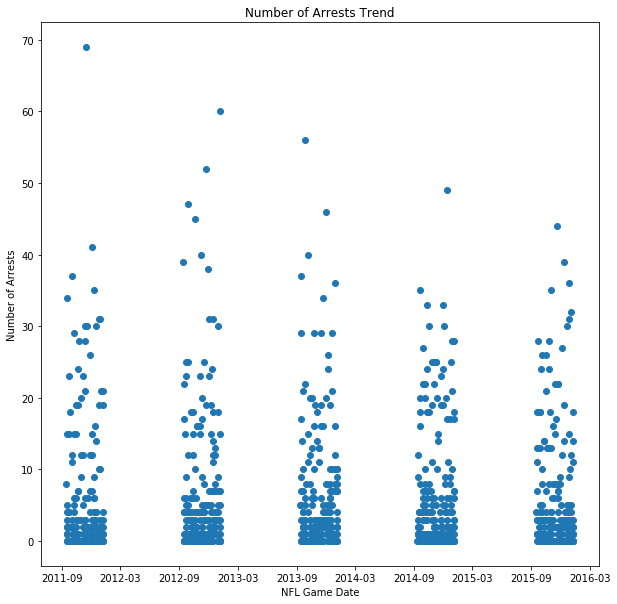

In [220]:
plt.figure(figsize=(10,10))
plt.xlabel('NFL Game Date')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests Trend')
plt.plot_date(stadium_test.date, stadium_test.arrests)
plt.savefig('Number of Arrests Trend', bbox_inches='tight')
plt.show()

Out of curiousity, I wanted to know the home team with the most arrests in aggregate over the entire dataset (2011 to 2015 seasons). I hypothesized that it would be the Oakland Raiders, because the fans are notoriously obnoxious and have a bad reputation for being disrepectful. I was surprised to see that Oakland only ranked 5th (658), behind San Deigo Chargers (983), NY Giants, NY Jets, and Pittsburgh Steelers, with San Diego ranked 1st. However, Oakland was ranked #2 (321) in the overall arrests as the away team, behind the Dallas Cowboys (328). Finally, a bit less surprising after the overall ranks, the highest overall arrests for a match up was the San Diego Chargers and the Oakland Raiders (197). 

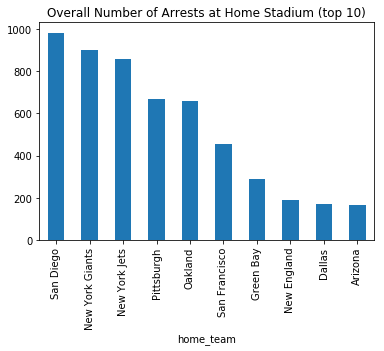

In [199]:
stadium_arr.groupby('home_team')['arrests'].sum().sort_values(ascending=False)[:10].plot(kind='bar', title='Overall Number of Arrests at Home Stadium (top 10)')

plt.savefig('overallArrestsAtHome.png', bbox_inches='tight')

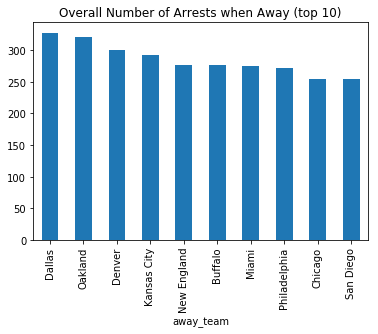

In [200]:
stadium_arr.groupby('away_team')['arrests'].sum().sort_values(ascending=False)[:10].plot(kind='bar', title='Overall Number of Arrests when Away (top 10)')

plt.savefig('overallArrestsAtAway.png', bbox_inches='tight')

In [201]:
pd.DataFrame(stadium_arr.groupby(['home_team','away_team'])['arrests'].sum().sort_values(ascending=False).reset_index())[:10]


,home_team,away_team,arrests
0,San Diego,Oakland,197.0
1,New York Giants,Dallas,174.0
2,New York Jets,New England,157.0
3,San Diego,Denver,133.0
4,New York Jets,Buffalo,125.0
5,New York Jets,Miami,117.0
6,Pittsburgh,Baltimore,115.0
7,San Diego,Kansas City,112.0
8,Oakland,San Diego,96.0
9,New York Giants,Philadelphia,95.0


Next, I wanted to look beyond the dataset of stadium arrests. To do so, I read in the per capita alcohol consumption by State and type of alcoholic beverage for the years from 1970 through 2016. In this analysis, I only looked at the years 2011 - 2015 to be consistent with the stadium arrests data. Further, I filtered the data to only include alcohol beverage type 4, which is all beverages. Further the data information indicates that we need to divide per capita gallons by 10,000 to obtain correct value.

In order to join the two datasets, I created a dictionary to map the NFL team to the state and another dictionary to map the state ID to the state in the alcohol consumption dataset. 

Finally, because the stadium arrests data is at the individual game level and the alcohol consumption is at the state level, I summarized the merged dataset to look at the state level.

In [202]:
state_dict = { 1 : 'Alabama',
               2 : 'Alaska',
               4 : 'Arizona',
               5 : 'Arkansas',
               6 : 'California',
               8 : 'Colorado',
               9 : 'Connecticut',
               10: 'Delaware',
               11:   'District of Columbia',
               12:   'Florida',
               13:   'Georgia',
               15:   'Hawaii',
               16:   'Idaho',
               17 :   'Illinois',
               18:   'Indiana',
               19:   'Iowa',
               20:   'Kansas',
               21:   'Kentucky',
               22 :  'Louisiana',
               23 :  'Maine',
               24  : 'Maryland',
               25   :'Massachusetts',
               26:   'Michigan',
               27 :  'Minnesota',
               28  : 'Mississippi',
               29:   'Missouri',
               30 :  'Montana',
               31 :  'Nebraska',
               32 :  'Nevada',
               33 :  'New Hampshire',
               34 :  'New Jersey',
               35 :  'New Mexico',
               36 :  'New York',
               37 :  'North Carolina',
               38 :  'North Dakota',
               39 :  'Ohio',
               40 : 'Oklahoma',
               41 :  'Oregon',
               42 :  'Pennsylvania',
               44 :  'Rhode Island',
               45 :  'South Carolina',
               46 :  'South Dakota',
               47 :  'Tennessee',
               48 :  'Texas',
               49 :  'Utah',
               50 : 'Vermont',
               51 :  'Virginia',
               53 :  'Washington',
               54 :  'West Virginia',
               55 :  'Wisconsin',
               56 :  'Wyoming',
               91 :  'Northeast Region',
               92 :  'Midwest Region',
               93 :  'South Region',
               94 :  'West Region',
               99 :  'United States',
 }

nfl_state_dict= {'Arizona': 'Arizona',
                 'Baltimore': 'Maryland',
                 'Carolina' : 'North Carolina',
                 'Chicago' : 'Illinois',
                 'Cincinnati': 'Ohio',
                 'Dallas' : 'Texas',
                 'Denver' : 'Colorado',
                 'Detroit': 'Michigan',
                 'Green Bay' : 'Wisconsin',
                 'Houston' : 'Texas',
                 'Indianapolis' : 'Indiana',
                 'Jacksonville' : 'Florida',
                 'Kansas City' : 'Kansas',
                 'Miami': 'Florida',
                 'New England' : 'Massachusetts',
                 'New York Giants' :'New York',
                 'New York Jets' : 'New York',
                 'Oakland': 'California',
                 'Philadelphia': 'Pennsylvania',
                 'Pittsburgh' : 'Pennsylvania',
                 'San Diego' : 'California',
                 'San Francisco' : 'California',
                 'Seattle' : 'Oregon',
                 'Tampa Bay' : 'Florida',
                 'Tennessee' : 'Tennessee',
                 'Washington' : 'Washington'}

stadium_arr['state'] = stadium_arr.home_team.map(nfl_state_dict)

# read in alcohol consumption data
consump = pd.read_fwf('./Data/pcyr1970-2016.txt', skiprows=128, sep=' ')
consump.columns = ['year', 'state', 'bev_type', 'gal_bev', 'gal_eth', 'pop_14', 'gal_eth_14', 'decile_14', 'pop_21', 'gal_eth_21', 'decile_21', 'source']
consump.state = consump.state.map(state_dict)
consump['gal_eth_21'] = consump['gal_eth_21']/10000
consump['gal_eth_14'] = consump['gal_eth_14']/10000 
consump = consump[(consump.bev_type == 4) & consump['year'].isin(range(2011,2016))]


# create new dataframes
# stadium = left join on stadium_arr
# summary = state level information on arrests and total ethanol consumed and ethanol consumed per capita aged over 21
stadium = stadium_arr.merge(consump, left_on=['state', 'season'], right_on=['state', 'year'], how='left')
summary = pd.DataFrame(stadium.groupby(['home_team', 'season']).agg({'arrests': np.sum, 'gal_eth_21':np.mean, 'gal_eth': np.sum}).sort_values(by='arrests', ascending=False)).reset_index()

After creating the new dataset that looks at years 2011-2015 only for alcohol consumption and only the states that have NFL stadiums, I explored the total amount of ethanol consumed and ethanol consumed per capita over the age of 21. I did not look at the other variable that had the enthanol conumed by ages 14 and above because I am assuming that the stadiums did not sell alcoholic beverages to anyone under the age of 21.

It looks like Wisconsin and Colorado has the highest gallons of ethanol consumed per capita aged 21 or above, but neither Green Bay Packers nor the Broncos ranked in the top 10 of most stadium arrests.

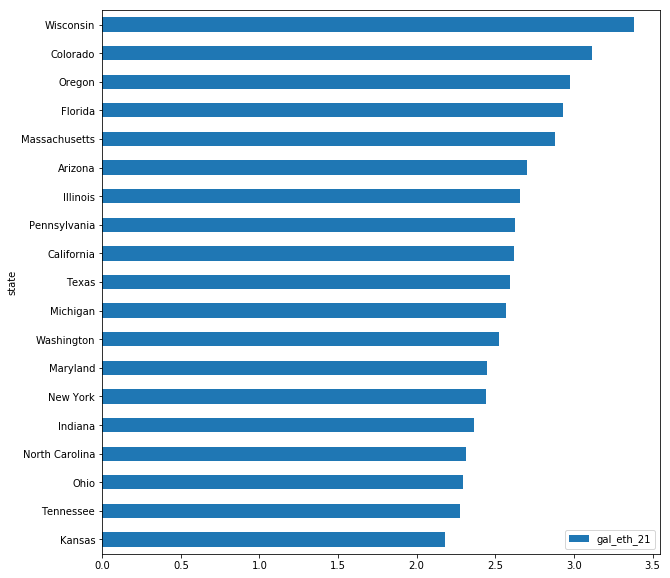

In [219]:
consump2 = consump[consump['state'].isin(stadium_arr.state.unique())]
consump2 = consump2[['state','gal_eth_21']].groupby('state').mean().sort_values(by='gal_eth_21', ascending= True).reset_index()
consump2.set_index('state', inplace=True)

consump2.plot(kind='barh',figsize=(10,10))
plt.savefig('AverageGalPer21.png', bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


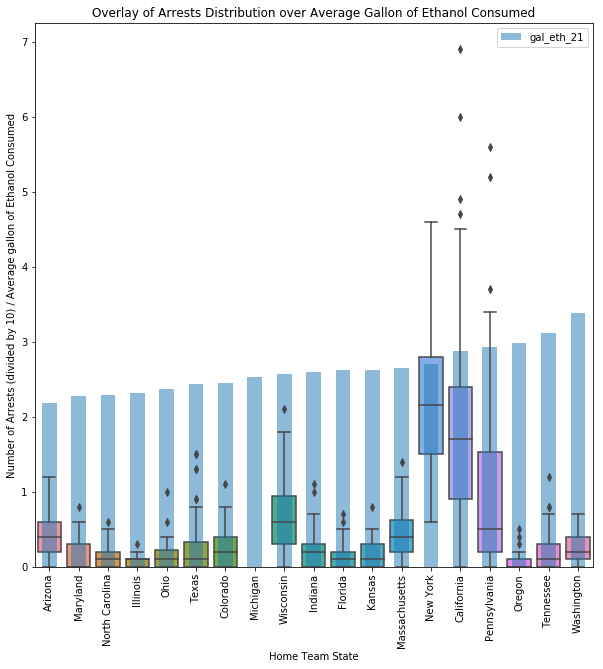

In [218]:
#overlay boxplot of arrests over gal_eth_21, divide arrests by 10 to scale it

consump2 = consump[consump['state'].isin(stadium_arr.state.unique())]
consump2 = consump2[['state','gal_eth_21']].groupby('state').mean().sort_values(by='gal_eth_21', ascending= True).reset_index()
consump2.set_index('state', inplace=True)

arrests = stadium[['state','arrests']]
arrests['arrests'] = arrests['arrests']/10

ax = consump2.plot(kind='bar',figsize=(10,10), alpha=0.5)
sns.boxplot(x='state', y='arrests', data=arrests, ax=ax)
plt.xlabel('Home Team State')
plt.ylabel('Number of Arrests (divided by 10) / Average gallon of Ethanol Consumed')
plt.title('Overlay of Arrests Distribution over Average Gallon of Ethanol Consumed')
plt.savefig('Overlay.png', bbox_inches='tight')
plt.show()

Next, I wanted to see which variables in the dataset has a statistically significant relationship with the number of arrests. I performed a simple linear regression on the variables OT, game_result, game_hour, and score_diff, individually, against the dependent variable arrests. The regressions determined that only game_result and game_hour are statistically significant, with p-values 0.0275 of 4.70e-06, respectively. 

### OT

Not statistically significant

In [205]:
model = sm.OLS.from_formula('arrests ~ OT', stadium_arr)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                arrests   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1339
Date:                Sat, 08 Sep 2018   Prob (F-statistic):              0.715
Time:                        16:05:28   Log-Likelihood:                -3546.1
No. Observations:                 966   AIC:                             7096.
Df Residuals:                     964   BIC:                             7106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.5385      0.315     20.726      0.0

### score_diff

Not statistically significant

In [206]:
model = sm.OLS.from_formula('arrests ~ score_diff', stadium_arr)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                arrests   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.755
Date:                Sat, 08 Sep 2018   Prob (F-statistic):             0.0973
Time:                        16:05:29   Log-Likelihood:                -3544.8
No. Observations:                 966   AIC:                             7094.
Df Residuals:                     964   BIC:                             7103.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2104      0.494     14.594      0.0

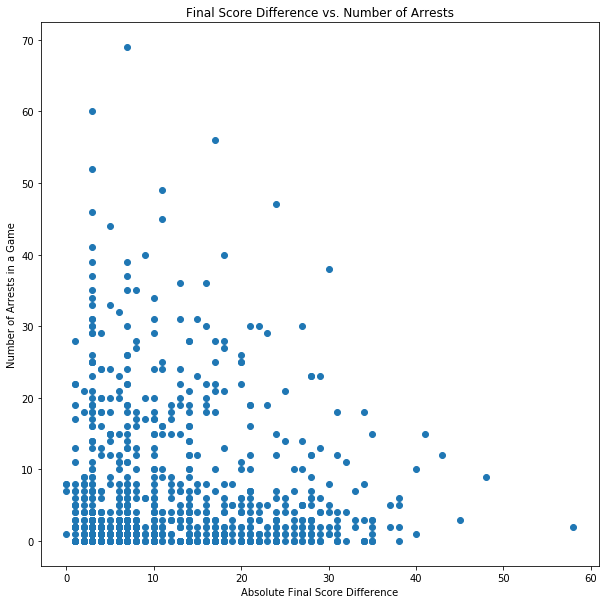

In [217]:
plt.figure(figsize=(10,10))
plt.scatter(stadium_arr.score_diff, stadium_arr.arrests)
plt.ylabel('Number of Arrests in a Game')
plt.xlabel('Absolute Final Score Difference')
plt.title('Final Score Difference vs. Number of Arrests')
plt.savefig('ScoreDiffArrests.png', bbox_inches='tight')
plt.show()

### game_result

The below suggests that when the home team wins, the expected number of arrests decreases by 1. However, stadium staff cannot predict the outcome of the game when they are making decisions for staffing. 

In [208]:
model = sm.OLS.from_formula('arrests ~ game_result', stadium_arr)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                arrests   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.871
Date:                Sat, 08 Sep 2018   Prob (F-statistic):             0.0275
Time:                        16:05:29   Log-Likelihood:                -3543.7
No. Observations:                 966   AIC:                             7091.
Df Residuals:                     964   BIC:                             7101.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.3563      0.471     15.633      

### game_hour
Looking at the hours of when the games started, it suggests that an increase in two hours of game start time (aka later in the day) increases the expected number of arrests by 1

In [209]:
model = sm.OLS.from_formula('arrests ~ game_hour', stadium_arr)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                arrests   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     21.20
Date:                Sat, 08 Sep 2018   Prob (F-statistic):           4.70e-06
Time:                        16:05:29   Log-Likelihood:                -3535.7
No. Observations:                 966   AIC:                             7075.
Df Residuals:                     964   BIC:                             7085.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1828      1.710     -0.692      0.4

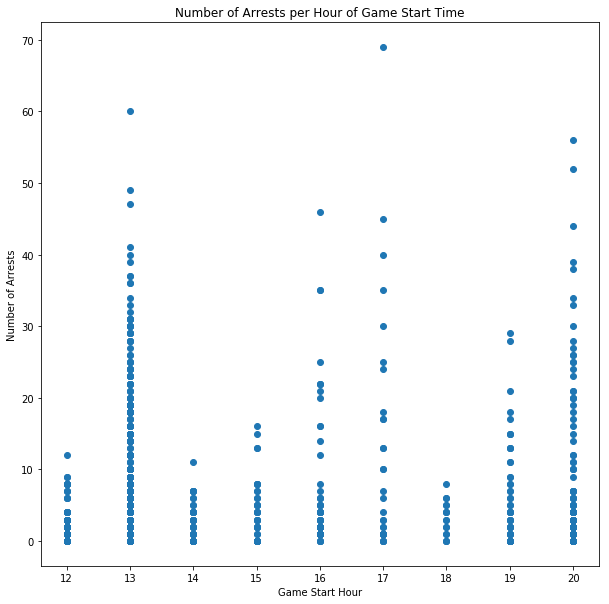

In [216]:
plt.figure(figsize=(10,10))
plt.scatter(stadium_arr.game_hour, stadium_arr.arrests)
plt.xlabel('Game Start Hour')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests per Hour of Game Start Time')
plt.savefig('ArrestsPerStartTime.png', bbox_inches='tight')
plt.show()

#### OLS - arrests for Gallons of ethanol per capita age 21 and older 

It appears that as the gallons of ethanol consumer per capita aged 21 and above increase, the number of arrest decrease.

In [211]:
model = sm.OLS.from_formula('arrests ~ gal_eth_21', stadium)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                arrests   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.045
Date:                Sat, 08 Sep 2018   Prob (F-statistic):             0.0249
Time:                        16:05:29   Log-Likelihood:                -3543.7
No. Observations:                 966   AIC:                             7091.
Df Residuals:                     964   BIC:                             7101.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.8871      2.831      4.552      0.0

#### OLS - arrest for Gallons of ethanol (absolute alcohol)

It appears that as the number of gallons of ethanol consumed by a state increase, the number of arrests increase. If the state consumed 10 million gallons of ethanol, the number of arrests at the football stadium may increase by about 2. 

In [212]:
model = sm.OLS.from_formula('arrests ~ gal_eth', summary)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                arrests   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     39.08
Date:                Sat, 08 Sep 2018   Prob (F-statistic):           6.46e-09
Time:                        16:05:29   Log-Likelihood:                -665.20
No. Observations:                 122   AIC:                             1334.
Df Residuals:                     120   BIC:                             1340.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7567      9.015      0.639      0.5

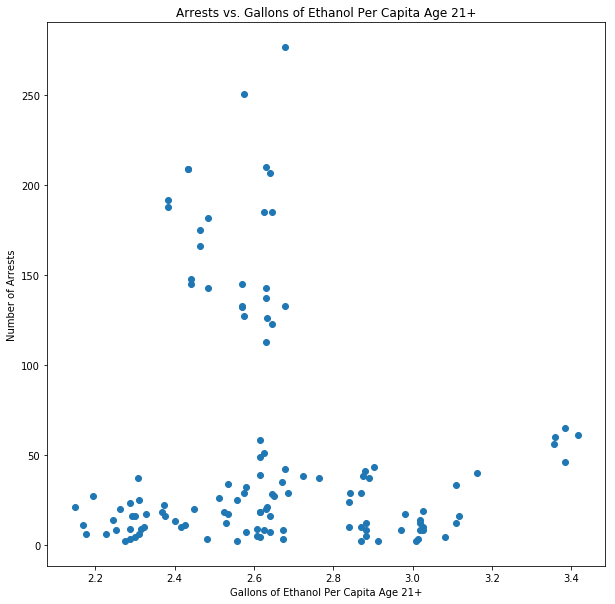

In [215]:
plt.figure(figsize=(10,10))
plt.scatter(summary.gal_eth_21, summary.arrests)
plt.xlabel('Gallons of Ethanol Per Capita Age 21+')
plt.ylabel('Number of Arrests')
plt.title('Arrests vs. Gallons of Ethanol Per Capita Age 21+')
plt.savefig('ArrestsVsAge21.png', bbox_inches='tight')
plt.show()




### Conclusion

While the datasets were interesting and I was surprised to see that Oakland did not have the most arrests, I did not find any strong or practical correlations or between any variables of the Stadium Arrests dataset or the Alcohol Consumption dataset, except when the game starts. Games that start later in the day tends to have a higher number of arrests. As such, stadium staff could hire more police for night games, however the number of arrest does not increase significantly as it gets later in the day (1 more arrest for every 2 hours later).